In [1]:
import caustics
from caustics import Module, forward, Param
from torch.nn.functional import conv2d, avg_pool2d
from caustics.utils import meshgrid
import numpy as np
from typing import Optional, Union, Annotated
import torch
from torch import Tensor
import matplotlib.pyplot as plt

# Building your own simulator from scratch: a tutorial

In this tutorial, we will build a fully-functional gravitational lensing simulator based on LensSource, the prebuilt simulator which comes with Caustics. We will then demonstrate how you can modify a custom simulator to extend its capabilities. 

### Part 1: The `__init__` function

First, we begin by creating a new **class** for our simulator. 
**For those new to object-oriented programming**: a class consists of a recipe for building an object. An object is a reusable container which contains functions and their parameters. 

We want our simulator to inherit from the **Module** class in Caustics, which is a basic framework for constructing simulator objects. In the `__init__` function, we need a few basic ingredients to create the simulator:
1. A lens mass distribution
2. A model for the lens light
3. A model for the source light
4. A model for the telescope PSF
5. A value for the pixel scale of the CCD
6. The number of pixels in the CCD
7. The upsample factor (increases the resolution of the simulator internally to improve accuracy)
8. The redshift of the source light (item 3)

We can also provide a name for the simulator.

Within our `__init__` function, we need to provide instructions to construct the basic structure of the simulator object, which is done by calling the `__init__` function of the `super` class, which in this case is `Module` from Caustics.

Within `__init__` we also need to construct the components of our simulator. For components which are constructed once (lens mass model, lens light model, source light model, and telescope psf), we simply need to make them a part of the current object (`self`). We do the same for parameters whose value we wish to only set once, such as the coordinate grid, which we generate with the `meshgrid` function of caustics. For parameters which we wish to sample with our MCMC (which are not already parameters of any of the existing components), we need to register them as a `Param` object, which will allow our simulator to find them in the flattened vector of parameters which we will pass to the simulator. In this example, we register the source redshift `z_s` as a `Param`. 

In [20]:
class Singlelens(Module):
    def __init__(
        self,
        lens,
        lens_light,
        source,
        psf,
        pixelscale,
        pixels_x,
        upsample_factor,
        z_s=None,
        name: str = "sim",
    ):
        super().__init__(name)

        self.lens = lens
        self.src = source
        self.psf = psf
        self.lens_light = lens_light
        self.upsample_factor = upsample_factor
        self.z_s = Param("z_s", z_s)
        
        # Create the high-resolution grid
        thx, thy = caustics.utils.meshgrid(
            pixelscale / upsample_factor,
            upsample_factor * pixels_x,
            dtype=torch.float32
        )
        
        # CHANGE THIS TO self.thx = thx
        self.thx = thx
        self.thy = thy
        
    @forward
    def forward(self):    
        # Ray-trace to get the lensed positions
        bx, by = self.lens.raytrace(self.thx, self.thy, self.z_s)
        
        # Evaluate the lensed source brightness at high resolution
        image = self.src.brightness(bx, by)
        
        # Add the lens light
        image += self.lens_light.brightness(self.thx, self.thy)
        
        # Downsample to the desired resolution
        image_ds = avg_pool2d(image[None, None], self.upsample_factor)[0, 0]
        
        
        # Convolve with the PSF using conv2d
        psf_normalized = (self.psf.T / self.psf.sum())[None, None]
        image_ds = conv2d(
            image_ds[None, None], psf_normalized, padding="same"
    ).squeeze(0).squeeze(0)
        
        return image_ds

### Part 2: the `forward` function

In the code above, in addition to the `__init__` function, you can see that we have added another function called `forward`. This is the part of our simulator object which will actually perform the simulation (when called). Our simulation has a few basic steps:

1. Raytrace the coordinates from the source plane to the lens plane using the lens mass distribution
2. Evaluate the brightness of the source light model in the lens plane (which creates the gravitationally lensed image)
3. Add lens light to the image
4. Downsample the image to the correct pixel scale
5. Convolve with the PSF of the telescope

### Part 3: Instantiating our simulator

Now that we have completed our custom simulator, we need to **instantiate** the components of the simulator and the simulator itself. The instantiation process creates an object in memory from a class.

In [21]:
# Cosmology model
cosmology = caustics.FlatLambdaCDM(name="cosmo")
# Source light model
source_light = caustics.Sersic(name="sourcelight")
# Lens mass model
epl = caustics.EPL(name="epl", cosmology=cosmology)
# Lens Light model
lens_light = caustics.Sersic(name="lenslight1")
# PSF and image resolution
pixscale=0.11/2
fwhm = 0.269  # full width at half maximum of PSF
psf_sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
psf_image = torch.as_tensor(caustics.utils.gaussian(
    nx=10,
    ny=10,
    pixelscale=pixscale,
    sigma=psf_sigma,
    upsample=1,
), dtype = torch.float32)
# Instantiate simulator
simulator = Singlelens(
    lens=epl,
    lens_light=lens_light,
    source=source_light,
    psf=psf_image,
    pixels_x=60*2,
    pixelscale=pixscale,
    upsample_factor=5)

Now that we have instantiated our simulator, we can visualize its structure using graphviz. The grayed out squares are parameters which are fixed, while the white squares are parameters which are registered as `Param` objects (known as **active parameters** in Caustics). The arrows indicate which object contains which component. 

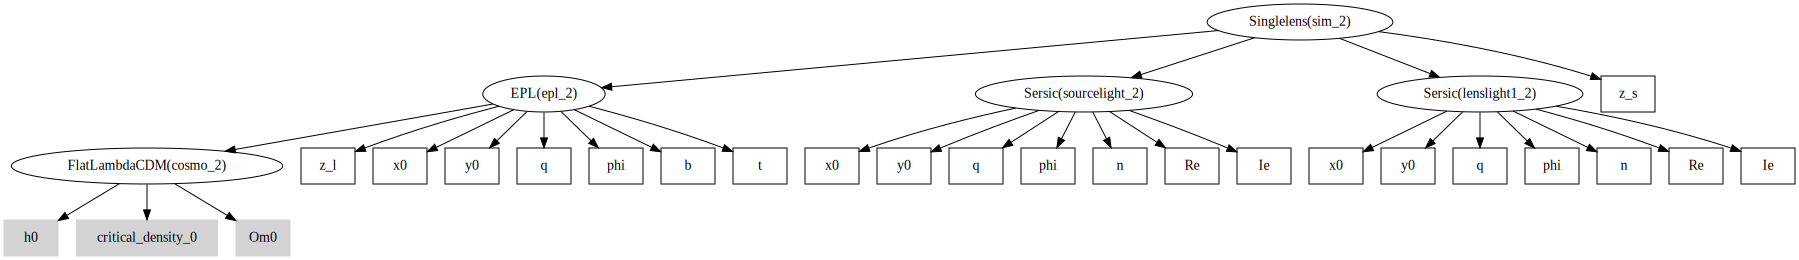

In [22]:
simulator.graphviz()

### Part 4: Passing parameters to our simulator

Now that we have 

In [8]:
print(simulator)

sim_0|module
    epl_0|module
        cosmo_0|module
            h0|static
            critical_density_0|static
            Om0|static
        z_l|dynamic
        x0|dynamic
        y0|dynamic
        q|dynamic
        phi|dynamic
        b|dynamic
        t|dynamic
    sourcelight_0|module
        x0|dynamic
        y0|dynamic
        q|dynamic
        phi|dynamic
        n|dynamic
        Re|dynamic
        Ie|dynamic
    lenslight1_0|module
        x0|dynamic
        y0|dynamic
        q|dynamic
        phi|dynamic
        n|dynamic
        Re|dynamic
        Ie|dynamic
    z_s|dynamic


In [ ]:
params_lens_mass = torch.tensor([
        0.25,  # epl x0
        0.3,  # epl y0
        1/1.14,  # epl q
        np.pi/2 + 1.6755160819145565,  # epl phi
        0.97,  # epl b
        1.04,   # epl t
    x0=0.25,y0=0.3,q=1-0.29,phi=-28/180*torch.pi,n=4,Re=0.84/6.646,Ie=36
    ])

In [ ]:
class Doublelens(Module):
    def __init__(
        self,
        lens,
        lens_light1,
        lens_light2,
        source,
        psf,
        pixelscale,
        pixels_x,
        upsample_factor,
        z_s=None,
        name: str = "sim",
    ):
        super().__init__(name)

        self.lens = lens
        self.src = source
        self.psf = torch.as_tensor(psf, dtype=torch.float32)
        self.lens_light1 = lens_light1
        self.lens_light2 = lens_light2
        self.upsample_factor = Param(upsample_factor)
        self.z_s = Param(z_s)
        
        # Create the high-resolution grid
        thx, thy = caustics.utils.meshgrid(
            pixelscale / upsample_factor,
            upsample_factor * pixels_x,
            dtype=torch.float32
        )
        
        # CHANGE THIS TO self.thx = thx
        self.thx = thx
        self.thy = thy
        
    @forward
    def forward(self):    
        # Ray-trace to get the lensed positions
        bx, by = self.lens.raytrace(self.thx, self.thy, self.z_s)
        
        # Evaluate the lensed source brightness at high resolution
        mu_fine = self.src.brightness(bx, by)
        
        # Add the lens light contributions
        mu_fine += self.lens_light1.brightness(self.thx, self.thy)
        mu_fine += self.lens_light2.brightness(self.thx, self.thy)
        
        # Downsample to the desired resolution
        mu = avg_pool2d(mu_fine[None, None], self.upsample_factor)[0, 0]
        
        
        # Convolve with the PSF using conv2d
        psf_normalized = (self.psf.T / self.psf.sum())[None, None]
        mu = conv2d(
            mu[None, None], psf_normalized, padding="same"
    ).squeeze(0).squeeze(0)
        
        return mu

In [ ]:
class Lens_only(caustics.Simulator):
    def __init__(
        self,
        lens_light,
        psf,
        pixelscale,
        pixels_x,
        upsample_factor,
        name: str = "sim",
    ):
        super().__init__(name)

        self.psf = torch.as_tensor(psf, dtype=torch.float32)
        self.lens_light = lens_light
        self.upsample_factor = upsample_factor

      
        # Create the high-resolution grid
        thx, thy = caustics.utils.meshgrid(
            pixelscale / upsample_factor,
            upsample_factor * pixels_x,
            dtype=torch.float32, device="cuda"
    )
        #thx=thx.requires_grad_()
        #thy=thy.requires_grad_()
        
        # CHANGE THIS TO self.thx = thx
        #self.thx = thx
        #self.thy = thy
        self.add_param("thx", thx)
        self.add_param("thy", thy)
        
    @forward
    def forward(self, params):
        # Unpack the parameters
        thx, thy = self.unpack(params)
        
        # Add the lens light contributions
        mu_fine = self.lens_light.brightness(thx, thy, params)
        
        # Downsample to the desired resolution
        mu = avg_pool2d(mu_fine[None, None], self.upsample_factor).squeeze(0).squeeze(0)
        
        # Convolve with the PSF using conv2d
        psf_normalized = ((torch.flip(self.psf, (0, 1))) / self.psf.sum())[None, None]
        mu = conv2d(
            mu[None, None], psf_normalized, padding="same"
    ).squeeze(0).squeeze(0)
        
        return mu